In [ ]:
import os 
from google.colab import drive
drive.mount("/content/drive")
os.chdir('/content/drive/Shared drives/IDS 576/Assignment 2')

!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'CNNs and fine tuning.ipynb'  'Movie Embeddings.ipynb'
 data			      'Untitled document.gdoc'


In [ ]:
# libraries 
import torch
import torchvision
import torchvision.transforms as transforms

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cpu')

1.1 - downloading the data 

In [ ]:
_image_size = 224
_mean = [0.485, 0.456, 0.406]
_std = [0.229, 0.224, 0.225]

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(_mean, _std)])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
batch_size = 128
n_classes = 10

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  car  deer  deer plane


In [ ]:

from torch.utils.data import DataLoader


train_dl = DataLoader(
    trainloader,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
)

val_dl = DataLoader(
    testloader,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
)

## 1.2 

In [ ]:
from torchvision import models

model = models.resnet18(pretrained=True)
for param in model.parameters():
        param.requires_grad = False


In [ ]:
# import torchsummary

# torchsummary.summary(model, (3, 224, 224), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
import torch.nn as nn
model.fc = nn.Linear(512, n_classes)
model = model.to(DEVICE)

In [ ]:
# loss function 
""" As stated in the torch.nn.CrossEntropyLoss() doc: This criterion combines nn.LogSoftmax() and nn.NLLLoss() in one single class.""" 

criterion = nn.CrossEntropyLoss()

In [ ]:
def get_trainable(model_params):
    return (p for p in model_params if p.requires_grad)

optimizer = torch.optim.Adam(
    get_trainable(model.parameters()),
    lr=0.001,
    # momentum=0.9,
)

In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.160
[1,  4000] loss: 2.091
[1,  6000] loss: 2.109
[1,  8000] loss: 2.096
[1, 10000] loss: 2.112
[1, 12000] loss: 2.062
[2,  2000] loss: 2.086
[2,  4000] loss: 2.054
[2,  6000] loss: 2.082
[2,  8000] loss: 2.093
[2, 10000] loss: 2.091
[2, 12000] loss: 2.088
Finished Training


In [ ]:
PATH = './cifar_model.pth'
torch.save(model.state_dict(), PATH)

# saving the model 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


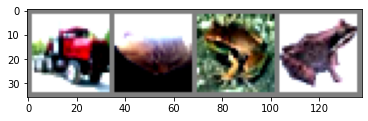

GroundTruth:  truck   cat  frog  frog


In [ ]:
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:  horse   cat  deer  deer


In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 30 %


In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 35 %
Accuracy of   car : 42 %
Accuracy of  bird :  8 %
Accuracy of   cat : 33 %
Accuracy of  deer : 49 %
Accuracy of   dog :  4 %
Accuracy of  frog : 39 %
Accuracy of horse : 33 %
Accuracy of  ship : 28 %
Accuracy of truck : 33 %
